# TCC CBB

#### Desenvolvido por Ricardo e Thyago.

#### Objetivo:

Este é uma das primeiras avaliações feitas com a utilização do PCA e do algoritmo MLP. Este código, possui duas avaliações exaustivas para a técnica. A primeira avaliação, consiste na análise de componentes para as técnicas, com esta análise é possível identificar os componentes que, possuem as melhores assertividades. A segunda avaliação, é a de teste/treino, aplica-se o K-fold variando de 0.1 até 1.0, para os conjuntos de componentes. Toda a aplicação é feita sobre a base de dados Churn in Telecom dataset's


### IMPORT DAS BIBLIOTECAS PADRÕES

In [1]:
import random

In [2]:
from sklearn.svm import SVC

In [3]:
import bigml.api
import os
import pandas as pd
from bigml.api import BigML
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

### Import do MLP

In [4]:
from sklearn import linear_model, model_selection, metrics
from sklearn.neural_network import MLPClassifier

### TRATANDO BASE DE DADOS

In [5]:
api = BigML('ricardomorellosantos','b34ec3c18161b1da38b0c5e04520224f7544405e')
api.download_dataset(dataset='dataset/5e356cd41efc9271bf006ea2', filename=os.getcwd()+'\\bigml.csv')

'C:\\Users\\Thyago M\\Desktop\\bigml.csv'

In [6]:
def converte_binario(palavra):
    if palavra=='Yes' or palavra==True:
        return 0
    elif palavra=='No' or palavra==False:
        return 1

In [7]:
def descarregaBaseDados():
    df_bigml = pd.read_csv(os.getcwd()+'\\bigml.csv')
    states = df_bigml['State'].value_counts()
    df_bigml['Voice mail plan'] = df_bigml['Voice mail plan'].apply(converte_binario)
    df_bigml['International plan'] = df_bigml['International plan'].apply(converte_binario)
    df_bigml['Churn'] = df_bigml['Churn'].apply(converte_binario)
    df_bigml_target = df_bigml['Churn']
    df_bigml.drop('Churn', axis=1, inplace=True)
    df_bigml_target.head()
    print(df_bigml_target.value_counts())
    array_estados = []
    i = 0
    for index, val in states.iteritems():
        array_estados.append(index)    
        i = 0
    for estado in array_estados:
        df_bigml['State'] = df_bigml['State'].replace(to_replace=estado, value=i)
        i = i+1
    return df_bigml, df_bigml_target

### K-FOLD DE PARAMETROS ESTATICOS

In [9]:
def aplicaKFold(x_pca, df_bigml_target):
    divisao = 0.2
    X_train, X_test, y_train, y_test = train_test_split(x_pca, df_bigml_target, test_size=divisao)
    return (X_train, X_test, y_train, y_test)

### K-FOL DE PARAMETROS DINAMICOS

In [8]:
def aplicaKFold2(x_pca, df_bigml_target, divisao):
    X_train, X_test, y_train, y_test = train_test_split(x_pca, df_bigml_target, test_size=divisao)
    return (X_train, X_test, y_train, y_test)

# MLP

In [9]:
def aplicaMLP(X_train, X_test, y_train):
    #X_train, X_test, y_train, y_test = model_selection.train_test_split(X_train, y_train, test_size=0.2, random_state=0)
   
    modelMLP = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
    modelMLP.fit(X_train, y_train)
    predictionsMLP = modelMLP.predict_proba(X_test)
    
    return predictionsMLP

# AVALIAÇÃO EXAUSTIVA DO MLP - BASEADO NO NÚMERO DE COMPONENTES

In [10]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt
import numpy as np

### Scaled Data

In [11]:
df_bigml, df_bigml_target = descarregaBaseDados()
scaler = StandardScaler()
scaler.fit(df_bigml)
scaled_data = scaler.transform(df_bigml)

1    2850
0     483
Name: Churn, dtype: int64


### Primeira avaliação - baseada no número de componentes

In [14]:
convergencia = False
auc_total = []
auc_num_componentes = []
media_anterior = 0

for numComponentes in range(1, 20):
    auc_componente = []
    media_anterior = 0
    qtd_iguais = 0

    pca_mlp = PCA(n_components = numComponentes)
    pca_mlp.fit(scaled_data)
    x_pca = pca_mlp.transform(scaled_data)

    convergencia = False
    print("Componente", numComponentes)

    while(not convergencia):

        X_train, X_test, y_train, y_test = aplicaKFold(x_pca, df_bigml_target)
        predictedprob = aplicaMLP(X_train, X_test, y_train)

        fpr, tpr, thresholds = roc_curve(y_test, predictedprob[:,1])

        roc_auc = auc(fpr, tpr)
        auc_componente.append(roc_auc)

        media_aucs = round(sum(auc_componente) / len(auc_componente), 2)

       # print("Media de AUCS", media_aucs)
       # print("ROC CURVE", roc_auc)
       # print("ROC AUC", auc_componente)

        if media_anterior == media_aucs:
            qtd_iguais = qtd_iguais + 1
        if qtd_iguais == 10:
            auc_num_componentes.append(media_aucs)
            auc_total.append(auc_componente)
            convergencia = True

        media_anterior = media_aucs  

Componente 1
Componente 2
Componente 3
Componente 4
Componente 5
Componente 6
Componente 7
Componente 8
Componente 9
Componente 10
Componente 11
Componente 12
Componente 13
Componente 14
Componente 15
Componente 16
Componente 17
Componente 18
Componente 19


### Gráfico de assertividade de componentes

In [15]:
import seaborn as sns
import numpy as np
df = pd.DataFrame()
df['Media'] = auc_num_componentes
df['Num Componentes'] = np.arange(1, 20)

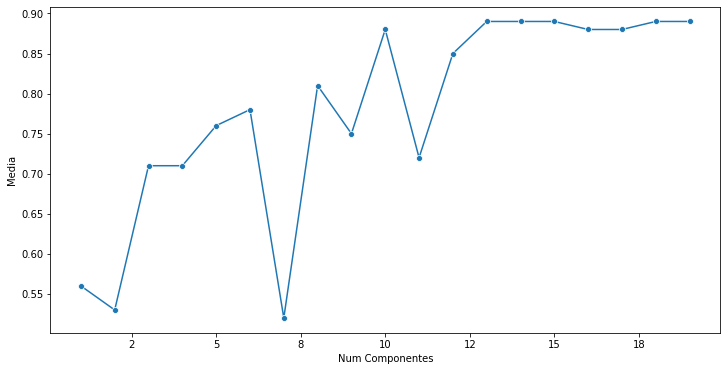

In [17]:
fig, ax = plt.subplots(figsize=(12, 6))  
g = sns.lineplot(y='Media', x = 'Num Componentes', data=df, marker = 'o')
xlabels = ['{:,.0f}'.format(x) for x in g.get_xticks()]
g.set_xticklabels(xlabels)
plt.savefig('media_pca_componentes_MLP-MODIFICADA-V3.png')

### Curva ROC

In [22]:
divisao = 0.1
pca_mlp = PCA(n_components = 17)
pca_mlp.fit(scaled_data)
x_pca = pca_mlp.transform(scaled_data)

X_train, X_test, y_train, y_test = aplicaKFold2(x_pca, df_bigml_target, divisao)
predictedprob = aplicaMLP(X_train, X_test, y_train)

fpr, tpr, thresholds = roc_curve(y_test, predictedprob[:,1])
roc_auc= auc(fpr, tpr)

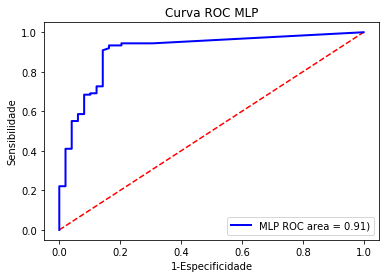

In [23]:
fig = plt.figure()
plt.xlabel('1-Especificidade')
plt.ylabel('Sensibilidade')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.title('Curva ROC MLP')
plt.plot(fpr, tpr, color='blue', lw=2, label='MLP ROC area = %0.2f)' % roc_auc)
plt.legend(loc="lower right")
plt.rcParams.update({'font.size': 10})
plt.show()
fig.savefig('ROC_MLP-V4.PNG')

#plt.rcParams.update({'font.size': 20})

### Segunda Avaliação -  TESTE/TREINO MLP

In [15]:
import time
import datetime

In [16]:
convergencia = False
auc_total = []
auc_num_componentes = []
media_anterior = 0
auc_divisao = []
numAucsComponentes = []
numAucsDivisao = []
tempo = datetime.datetime.now() 
ini = time.time()
for divisao in np.arange(0.1, 1, 0.1):
    print("DIVISAO DA BASE DE DADOS0++++++++++++++++++++++++++++++", divisao)
    
    for numComponentes in range(1,20):
        print(numComponentes)
        
        auc_componente = []
        media_anterior = 0
        qtd_iguais = 0
        pca_MLP2 = PCA(n_components = numComponentes)
        pca_MLP2.fit(scaled_data)
        x_pca_MLP2 = pca_MLP2.transform(scaled_data)
        
        convergencia = False
        print("COMPONENTE++++++++++++++++++++++++++++++++++++++", numComponentes)
    
        while(not convergencia):
            X_train, X_test, y_train, y_test = aplicaKFold2(x_pca_MLP2, df_bigml_target, divisao)
            predictedprob = aplicaMLP(X_train, X_test, y_train)
           
            fpr, tpr, thresholds = roc_curve(y_test, predictedprob[:,1])
            roc_auc = auc(fpr, tpr)
            
            auc_componente.append(roc_auc)#FEITO
            media_aucs = round(sum(auc_componente) / len(auc_componente), 2)#feito
           
            if media_anterior == media_aucs:
                qtd_iguais = qtd_iguais + 1
                
            if qtd_iguais == 10:
                
                numAucsComponentes.append(len(auc_componente))
                auc_total.append(media_aucs)
                convergencia = True  
                
            media_anterior = media_aucs            
    numAucsDivisao.append(numAucsComponentes)
    auc_divisao.append(auc_total)
    numAucsComponentes = []
    auc_total = []   
    
fim = time.time()
tempo2 = datetime.datetime.now() 

print("TEMPO", fim-ini)  
retorno_tempo = tempo2-tempo
print(retorno_tempo)

DIVISAO DA BASE DE DADOS0++++++++++++++++++++++++++++++ 0.1
1
COMPONENTE++++++++++++++++++++++++++++++++++++++ 1
2
COMPONENTE++++++++++++++++++++++++++++++++++++++ 2
3
COMPONENTE++++++++++++++++++++++++++++++++++++++ 3
4
COMPONENTE++++++++++++++++++++++++++++++++++++++ 4
5
COMPONENTE++++++++++++++++++++++++++++++++++++++ 5
6
COMPONENTE++++++++++++++++++++++++++++++++++++++ 6
7
COMPONENTE++++++++++++++++++++++++++++++++++++++ 7
8
COMPONENTE++++++++++++++++++++++++++++++++++++++ 8
9
COMPONENTE++++++++++++++++++++++++++++++++++++++ 9
10
COMPONENTE++++++++++++++++++++++++++++++++++++++ 10
11
COMPONENTE++++++++++++++++++++++++++++++++++++++ 11
12
COMPONENTE++++++++++++++++++++++++++++++++++++++ 12
13
COMPONENTE++++++++++++++++++++++++++++++++++++++ 13
14
COMPONENTE++++++++++++++++++++++++++++++++++++++ 14
15
COMPONENTE++++++++++++++++++++++++++++++++++++++ 15
16
COMPONENTE++++++++++++++++++++++++++++++++++++++ 16
17
COMPONENTE++++++++++++++++++++++++++++++++++++++ 17
18
COMPONENTE++++++++++

11
COMPONENTE++++++++++++++++++++++++++++++++++++++ 11
12
COMPONENTE++++++++++++++++++++++++++++++++++++++ 12
13
COMPONENTE++++++++++++++++++++++++++++++++++++++ 13
14
COMPONENTE++++++++++++++++++++++++++++++++++++++ 14
15
COMPONENTE++++++++++++++++++++++++++++++++++++++ 15
16
COMPONENTE++++++++++++++++++++++++++++++++++++++ 16
17
COMPONENTE++++++++++++++++++++++++++++++++++++++ 17
18
COMPONENTE++++++++++++++++++++++++++++++++++++++ 18
19
COMPONENTE++++++++++++++++++++++++++++++++++++++ 19
DIVISAO DA BASE DE DADOS0++++++++++++++++++++++++++++++ 0.9
1
COMPONENTE++++++++++++++++++++++++++++++++++++++ 1
2
COMPONENTE++++++++++++++++++++++++++++++++++++++ 2
3
COMPONENTE++++++++++++++++++++++++++++++++++++++ 3
4
COMPONENTE++++++++++++++++++++++++++++++++++++++ 4
5
COMPONENTE++++++++++++++++++++++++++++++++++++++ 5
6
COMPONENTE++++++++++++++++++++++++++++++++++++++ 6
7
COMPONENTE++++++++++++++++++++++++++++++++++++++ 7
8
COMPONENTE++++++++++++++++++++++++++++++++++++++ 8
9
COMPONENTE+++++++++

### Gráfico Mapa de Calor MLP

In [17]:
def add(x):
    return x+1

#df_divisaodf.astype (float)

In [24]:
auc_divisao

[[0.56,
  0.56,
  0.71,
  0.7,
  0.77,
  0.79,
  0.5,
  0.82,
  0.77,
  0.89,
  0.7,
  0.88,
  0.91,
  0.9,
  0.91,
  0.89,
  0.89,
  0.91,
  0.88],
 [0.58,
  0.55,
  0.72,
  0.7,
  0.75,
  0.78,
  0.54,
  0.83,
  0.75,
  0.88,
  0.71,
  0.85,
  0.9,
  0.89,
  0.9,
  0.88,
  0.88,
  0.9,
  0.9],
 [0.56,
  0.55,
  0.72,
  0.71,
  0.75,
  0.78,
  0.53,
  0.81,
  0.78,
  0.88,
  0.71,
  0.85,
  0.88,
  0.89,
  0.89,
  0.86,
  0.88,
  0.9,
  0.89],
 [0.57,
  0.53,
  0.72,
  0.71,
  0.76,
  0.76,
  0.54,
  0.79,
  0.75,
  0.87,
  0.73,
  0.86,
  0.88,
  0.87,
  0.88,
  0.85,
  0.88,
  0.88,
  0.89],
 [0.55,
  0.51,
  0.71,
  0.7,
  0.76,
  0.76,
  0.56,
  0.81,
  0.75,
  0.88,
  0.73,
  0.85,
  0.85,
  0.87,
  0.87,
  0.83,
  0.88,
  0.89,
  0.88],
 [0.56,
  0.54,
  0.71,
  0.71,
  0.75,
  0.76,
  0.51,
  0.8,
  0.72,
  0.87,
  0.71,
  0.82,
  0.83,
  0.87,
  0.85,
  0.84,
  0.85,
  0.85,
  0.87],
 [0.54,
  0.53,
  0.71,
  0.69,
  0.74,
  0.76,
  0.57,
  0.78,
  0.71,
  0.84,
  0.7,
  0.81,

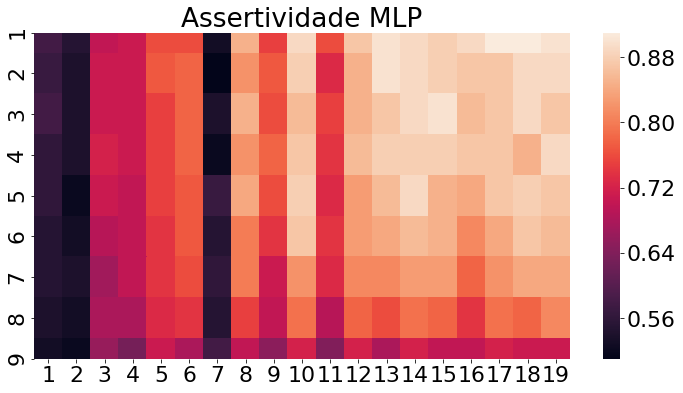

In [20]:
import seaborn as sns
fig = plt.figure(figsize = (12,6))

df_divisao = pd.DataFrame(auc_divisao)
df_divisao.set_index(np.arange(1,10), inplace = True)
df_divisao.rename(add, axis='columns', inplace=True)
sns.heatmap(data = df_divisao)
plt.title("Assertividade MLP")
plt.savefig('assertividade-MLP-divisao-numcomponente-MODIFICADANOVA.PNG')
plt.rcParams.update({'font.size': 22})

In [21]:
df_divisao

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
1,0.58,0.55,0.70,0.71,0.76,0.76,0.53,0.85,0.75,0.89,0.76,0.87,0.90,0.89,0.88,0.89,0.91,0.91,0.90
2,0.57,0.54,0.71,0.71,0.77,0.78,0.51,0.82,0.77,0.88,0.73,0.85,0.90,0.89,0.88,0.87,0.87,0.89,0.89
3,0.58,0.54,0.71,0.71,0.75,0.78,0.54,0.85,0.76,0.86,0.75,0.85,0.87,0.89,0.90,0.86,0.87,0.89,0.87
4,0.56,0.54,0.72,0.71,0.75,0.78,0.52,0.82,0.78,0.87,0.74,0.86,0.88,0.88,0.88,0.87,0.87,0.85,0.89
5,0.56,0.52,0.71,0.70,0.75,0.77,0.57,0.84,0.76,0.88,0.73,0.83,0.86,0.89,0.85,0.84,0.87,0.88,0.87
6,0.55,0.53,0.69,0.70,0.74,0.77,0.55,0.80,0.74,0.87,0.74,0.83,0.84,0.86,0.85,0.81,0.84,0.87,0.86
7,0.55,0.54,0.67,0.70,0.74,0.76,0.56,0.80,0.71,0.82,0.73,0.81,0.81,0.83,0.83,0.78,0.82,0.84,0.84
8,0.54,0.53,0.68,0.68,0.73,0.74,0.55,0.75,0.70,0.79,0.69,0.78,0.76,0.79,0.78,0.74,0.79,0.78,0.81
9,0.53,0.52,0.66,0.63,0.71,0.68,0.58,0.70,0.65,0.72,0.64,0.72,0.68,0.72,0.70,0.70,0.72,0.71,0.71


### Gráfico de quantidade de iterações do MLP até sua convergência

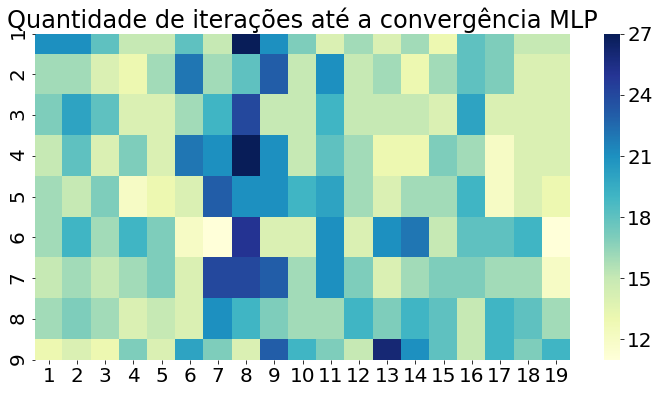

In [19]:
import seaborn as sns
fig = plt.figure(figsize = (12,6))

df = pd.DataFrame(numAucsDivisao)
df.set_index(np.arange(1,10), inplace = True)
df.rename(add, axis='columns', inplace=True)
sns.heatmap(data = df, cmap = 'YlGnBu')
plt.title("Quantidade de iterações até a convergência MLP")
plt.savefig('iteracoes-mlp-divisao-numcomponentes-MODIFICADA.PNG')

In [20]:
df

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
1,21,21,18,15,15,18,15,27,21,17,14,16,14,16,13,18,17,15,15
2,16,16,14,13,16,22,16,18,23,15,21,15,16,13,16,18,17,14,14
3,17,20,18,14,14,16,19,24,15,15,19,15,15,15,14,20,14,14,14
4,15,18,14,17,14,22,21,27,21,15,18,16,13,13,17,16,12,14,14
5,16,15,17,12,13,14,23,21,21,19,20,16,14,16,16,19,12,14,13
6,16,19,16,19,17,12,11,25,14,14,21,14,21,22,15,18,18,19,11
7,15,16,15,16,17,14,24,24,23,16,21,17,14,16,17,17,16,16,12
8,16,17,16,14,15,14,21,19,17,16,16,19,17,19,18,15,19,18,16
9,13,14,13,17,14,20,17,14,23,19,17,15,26,21,18,15,19,17,19
